# Develop a machine learning model to predict age, given a set of image derived phenotype data using UK Biobank

This notebook provides a supplementary material for the publicly available DNAnexus blog post and for the seminar "Jak stary je vas mozek" at Faculty of Mathematics and Physics, Prague (28 Feb 2024).

## As-Is Software Disclaimer

This notebook is delivered "As-Is". Notwithstanding anything to the contrary, DNAnexus will have no warranty, support, liability or other obligations with respect to Materials provided hereunder.

[MIT License](https://github.com/dnanexus/UKB_RAP/blob/main/LICENSE) applies to this notebook.

## Author
Ondrej Klempir, Senior Community Engagement Scientist at DNAnexus

## Dependencies
Standard set of Python libraries for plotting and machine learning. No special third party software required.

## Introduction
This notebook:

- loads exported image derived phenotypes (IDPs) data from real UKB participants
- explores basic descriptive characteristics of exported IDPs and calculate correlation matrix
- uses Cholesky decomposition method to generate simulated data, using a random multivariate normal distribution
- saves generated data as a csv, for modeling part
- example codebase for brain-age modeling follows, using lasso regression and cross-validation to evaluate our model

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.model_selection import cross_validate, KFold
from sklearn import metrics
from sklearn.base import clone
from sklearn.decomposition import PCA
%config InlineBackend.figure_format == 'retina'

import warnings
warnings.filterwarnings('ignore')

# Generate simulated data
### do not rerun this part, serves just for inspection on how simulated data was generated

## Preprocess original exported UKB IDPs

In [2]:
df_IDPs_vs_age = pd.read_csv('neuro_IDPs_dataset.csv')

In [3]:
df_IDPs_vs_age = df_IDPs_vs_age[df_IDPs_vs_age['Age at recruitment'].notnull()]

In [6]:
df_IDPs_vs_age.shape

(3243, 26)

In [40]:
df_IDPs_vs_age.columns

Index(['Age at recruitment', 'Volume of brain, grey+white matter | Instance 2',
       'Volume of brain, grey+white matter | Instance 3',
       'Volume of brain, grey+white matter (normalised for head size) | Instance 2',
       'Volume of brain, grey+white matter (normalised for head size) | Instance 3',
       'Volume of white matter (normalised for head size) | Instance 2',
       'Volume of white matter (normalised for head size) | Instance 3',
       'Volume of white matter | Instance 2',
       'Volume of white matter | Instance 3',
       'Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 2',
       'Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 3',
       'Volume of hippocampus (left) | Instance 2',
       'Volume of hippocampus (left) | Instance 3',
       'Volume of hippocampus (right) | Instance 2',
       'Volume of hippocampus (right) | Instance 3',
       'Volume of Hippocampus (left hemisphere

## Exploration, inspect whether individual IDP distribution is normal, compute corrs

<Axes: xlabel='Volume of brain, grey+white matter | Instance 3', ylabel='Density'>

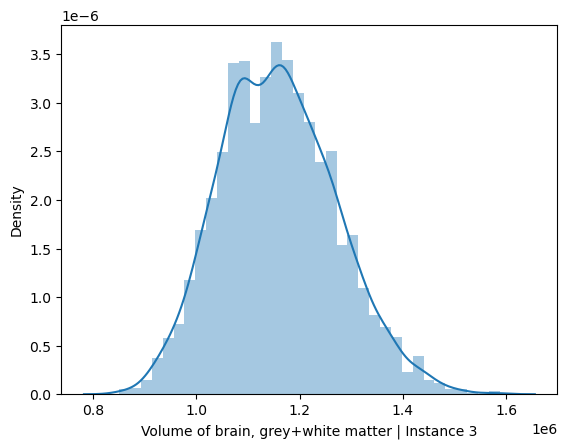

In [8]:
sns.distplot(df_IDPs_vs_age['Volume of brain, grey+white matter | Instance 3']) # plot distribution of one selected image parameter, using seaborn

In [9]:
df_IDPs_vs_age.corr()

,Age at recruitment,"Volume of brain, grey+white matter | Instance 2","Volume of brain, grey+white matter | Instance 3","Volume of brain, grey+white matter (normalised for head size) | Instance 2","Volume of brain, grey+white matter (normalised for head size) | Instance 3",Volume of white matter (normalised for head size) | Instance 2,Volume of white matter (normalised for head size) | Instance 3,Volume of white matter | Instance 2,Volume of white matter | Instance 3,Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 2,Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 3,Volume of hippocampus (left) | Instance 2,Volume of hippocampus (left) | Instance 3,Volume of hippocampus (right) | Instance 2,Volume of hippocampus (right) | Instance 3,Volume of Hippocampus (left hemisphere) | Instance 2,Volume of Hippocampus (left hemisphere) | Instance 3,Volume of Hippocampus (right hemisphere) | Instance 2,Volume of Hippocampus (right hemisphere) | Instance 3
Age at recruitment,1.000000,-0.240217,-0.260487,-0.528437,-0.563521,-0.283791,-0.336675,-0.122679,-0.151567,0.350151,0.376695,-0.218334,-0.274718,-0.222679,-0.275053,-0.300589,-0.346132,-0.300224,-0.351698
"Volume of brain, grey+white matter | Instance 2",-0.240217,1.000000,0.990648,0.253940,0.255593,0.429295,0.424252,0.958401,0.952517,0.041911,0.026748,0.449044,0.446335,0.525768,0.528818,0.666313,0.638974,0.671124,0.654889
"Volume of brain, grey+white matter | Instance 3",-0.260487,0.990648,1.000000,0.260117,0.279804,0.426915,0.443103,0.946502,0.959719,0.030661,0.025078,0.449522,0.450806,0.524223,0.534092,0.661732,0.651163,0.667957,0.668999
"Volume of brain, grey+white matter (normalised for head size) | Instance 2",-0.528437,0.253940,0.260117,1.000000,0.956627,0.797565,0.765736,0.192662,0.200954,-0.249200,-0.240074,0.202930,0.254740,0.186549,0.239246,0.238141,0.272174,0.240366,0.279738
"Volume of brain, grey+white matter (normalised for head size) | Instance 3",-0.563521,0.255593,0.279804,0.956627,1.000000,0.743523,0.809054,0.185110,0.221045,-0.254880,-0.253529,0.220961,0.272245,0.202314,0.258950,0.254379,0.297190,0.256611,0.305748
Volume of white matter (normalised for head size) | Instance 2,-0.283791,0.429295,0.426915,0.797565,0.743523,1.000000,0.898446,0.529161,0.502136,-0.038834,-0.031977,0.246706,0.287867,0.257481,0.288884,0.278992,0.299837,0.277189,0.301373
Volume of white matter (normalised for head size) | Instance 3,-0.336675,0.424252,0.443103,0.765736,0.809054,0.898446,1.000000,0.486974,0.539199,-0.063289,-0.062773,0.277241,0.304647,0.276149,0.304303,0.304191,0.321414,0.300934,0.324500
Volume of white matter | Instance 2,-0.122679,0.958401,0.946502,0.192662,0.185110,0.529161,0.486974,1.000000,0.977547,0.124058,0.110430,0.419226,0.415658,0.497007,0.492767,0.605914,0.578363,0.607920,0.589450
Volume of white matter | Instance 3,-0.151567,0.952517,0.959719,0.200954,0.221045,0.502136,0.539199,0.977547,1.000000,0.105108,0.099479,0.429901,0.422900,0.501356,0.499603,0.611008,0.592121,0.613371,0.605029
Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 2,0.350151,0.041911,0.030661,-0.249200,-0.254880,-0.038834,-0.063289,0.124058,0.105108,1.000000,0.790975,-0.048190,-0.088013,-0.063574,-0.079876,-0.045765,-0.076412,-0.044485,-0.074096


In [10]:
df_IDPs_vs_age.drop(columns=['Age at recruitment']).corrwith(df_IDPs_vs_age['Age at recruitment']).sort_values(ascending=False).round(2)

Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 3    0.38
Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 2    0.35
Volume of white matter | Instance 2                                                        -0.12
Volume of white matter | Instance 3                                                        -0.15
Volume of hippocampus (left) | Instance 2                                                  -0.22
Volume of hippocampus (right) | Instance 2                                                 -0.22
Volume of brain, grey+white matter | Instance 2                                            -0.24
Volume of brain, grey+white matter | Instance 3                                            -0.26
Volume of hippocampus (left) | Instance 3                                                  -0.27
Volume of hippocampus (right) | Instance 3                                                 -0.28
Volume of white matter (normal

### Use Cholesky decomposition to simulate correlated data
https://stats.stackexchange.com/questions/160054/how-to-use-the-cholesky-decomposition-or-an-alternative-for-correlated-data-si

##### A brief method explanation is available at
https://rinterested.github.io/statistics/multivariate_normal_draws.html

In [11]:
no_obs = 5000 # Number of observations per column
no_cols = df_IDPs_vs_age.shape[1]  # Number of image derived phenotypes

means = df_IDPs_vs_age.mean(axis=0).values.tolist() # Extract means of IDPs for original data       
sds = df_IDPs_vs_age.std(axis=0).values.tolist() # Extract standard devs of IDPs for original data 

sd = np.diag(sds) # SD in a diagonal matrix for later operations

In [12]:
observations = np.random.normal(0, 1, (no_cols, no_obs)) # Generate multivariate normal distribution, e.g. Rd draws N(0,1) in [3 x 1,000]

In [13]:
observations.shape

(19, 5000)

In [15]:
cor_matrix = df_IDPs_vs_age.corr().to_numpy()     # Save correlation matrix in numpy

In [16]:
cov_matrix = np.dot(sd, np.dot(cor_matrix, sd))   # The covariance matrix

In [17]:
Chol = np.linalg.cholesky(cov_matrix)             # Cholesky decomposition

In [18]:
sam_eq_mean = Chol.dot(observations)             # Generating random MVN (0, cov_matrix)

In [20]:
s = sam_eq_mean.transpose() + means               # Adding the means column wise
samples = s.transpose()                           # Transposing back

In [22]:
samples.T.shape

(5000, 19)

In [41]:
ukbb_simulated_df = pd.DataFrame(data = samples.T, columns = df_IDPs_vs_age.columns).astype('int').abs() # create a pd df table, apply int-abs to get nonnegative integers

In [42]:
ukbb_simulated_df

,Age at recruitment,"Volume of brain, grey+white matter | Instance 2","Volume of brain, grey+white matter | Instance 3","Volume of brain, grey+white matter (normalised for head size) | Instance 2","Volume of brain, grey+white matter (normalised for head size) | Instance 3",Volume of white matter (normalised for head size) | Instance 2,Volume of white matter (normalised for head size) | Instance 3,Volume of white matter | Instance 2,Volume of white matter | Instance 3,Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 2,Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 3,Volume of hippocampus (left) | Instance 2,Volume of hippocampus (left) | Instance 3,Volume of hippocampus (right) | Instance 2,Volume of hippocampus (right) | Instance 3,Volume of Hippocampus (left hemisphere) | Instance 2,Volume of Hippocampus (left hemisphere) | Instance 3,Volume of Hippocampus (right hemisphere) | Instance 2,Volume of Hippocampus (right hemisphere) | Instance 3
0,52,1226013,1211722,1417656,1402582,661455,641499,572647,555495,3614,3168,4520,4382,3940,3833,4269,4226,4448,4468
1,52,1064940,1024063,1438378,1441895,673018,677229,501877,483741,4317,6797,3641,3097,3339,3225,3647,3542,4095,4018
2,52,1167709,1142879,1568829,1556903,734279,731509,547365,537840,2281,431,3405,3419,3536,3297,3564,3593,3823,3600
3,58,1313668,1291795,1581691,1544468,790313,762232,654516,636391,9070,5323,4076,3854,3825,4180,4463,4247,4402,4261
4,49,1186355,1164466,1579336,1538992,708278,693700,534607,527148,7357,11858,3411,3235,3899,3640,3458,3536,4094,4277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,49,1402511,1385301,1520609,1529464,745253,752428,684303,678201,12882,9630,4800,4663,4738,4997,4742,4657,4865,4878
4996,57,1163918,1165286,1456739,1456451,701366,676881,561652,543761,10467,12064,3399,3530,3901,4069,3516,3695,3911,3900
4997,59,1375106,1371140,1558736,1535495,762239,734493,671536,655679,8060,7441,3924,4021,4308,3914,4223,4207,4371,4492
4998,53,1033012,1024300,1445731,1403699,687432,665225,492542,486904,2097,2136,3541,3556,3254,3288,3338,3417,3668,3497


### Inspect correlation consistency

In [43]:
ukbb_simulated_df.corr()

,Age at recruitment,"Volume of brain, grey+white matter | Instance 2","Volume of brain, grey+white matter | Instance 3","Volume of brain, grey+white matter (normalised for head size) | Instance 2","Volume of brain, grey+white matter (normalised for head size) | Instance 3",Volume of white matter (normalised for head size) | Instance 2,Volume of white matter (normalised for head size) | Instance 3,Volume of white matter | Instance 2,Volume of white matter | Instance 3,Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 2,Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 3,Volume of hippocampus (left) | Instance 2,Volume of hippocampus (left) | Instance 3,Volume of hippocampus (right) | Instance 2,Volume of hippocampus (right) | Instance 3,Volume of Hippocampus (left hemisphere) | Instance 2,Volume of Hippocampus (left hemisphere) | Instance 3,Volume of Hippocampus (right hemisphere) | Instance 2,Volume of Hippocampus (right hemisphere) | Instance 3
Age at recruitment,1.000000,-0.243174,-0.261846,-0.532960,-0.568643,-0.301360,-0.356646,-0.132007,-0.160775,0.254943,0.297247,-0.215166,-0.274968,-0.235572,-0.287101,-0.287745,-0.331576,-0.289880,-0.342200
"Volume of brain, grey+white matter | Instance 2",-0.243174,1.000000,0.991094,0.244156,0.243014,0.429478,0.424018,0.961399,0.955608,0.029509,0.003380,0.433225,0.430327,0.531183,0.527035,0.659543,0.635236,0.663220,0.647787
"Volume of brain, grey+white matter | Instance 3",-0.261846,0.991094,1.000000,0.250086,0.267170,0.426179,0.442378,0.949469,0.962094,0.019730,-0.001050,0.433768,0.435428,0.530659,0.533046,0.656801,0.648900,0.660566,0.662948
"Volume of brain, grey+white matter (normalised for head size) | Instance 2",-0.532960,0.244156,0.250086,1.000000,0.956024,0.802871,0.765591,0.185099,0.191715,-0.203350,-0.195077,0.194872,0.252864,0.188094,0.242346,0.226355,0.256037,0.229955,0.264682
"Volume of brain, grey+white matter (normalised for head size) | Instance 3",-0.568643,0.243014,0.267170,0.956024,1.000000,0.749704,0.809698,0.176067,0.209377,-0.200180,-0.204387,0.211599,0.269717,0.201910,0.261253,0.239503,0.280849,0.242097,0.289032
Volume of white matter (normalised for head size) | Instance 2,-0.301360,0.429478,0.426179,0.802871,0.749704,1.000000,0.898301,0.522616,0.494884,-0.047656,-0.040640,0.241530,0.284135,0.259822,0.290363,0.272840,0.289562,0.272044,0.290025
Volume of white matter (normalised for head size) | Instance 3,-0.356646,0.424018,0.442378,0.765591,0.809698,0.898301,1.000000,0.483220,0.533544,-0.051713,-0.059252,0.268920,0.298882,0.279182,0.305437,0.300216,0.314873,0.294615,0.314984
Volume of white matter | Instance 2,-0.132007,0.961399,0.949469,0.185099,0.176067,0.522616,0.483220,1.000000,0.978296,0.088636,0.066261,0.406417,0.400474,0.501608,0.490282,0.601453,0.576121,0.602420,0.583439
Volume of white matter | Instance 3,-0.160775,0.955608,0.962094,0.191715,0.209377,0.494884,0.533544,0.978296,1.000000,0.076572,0.056753,0.415077,0.406794,0.507224,0.497262,0.609481,0.592405,0.608611,0.600910
Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 2,0.254943,0.029509,0.019730,-0.203350,-0.200180,-0.047656,-0.051713,0.088636,0.076572,1.000000,0.700847,-0.048096,-0.084894,-0.069148,-0.082883,-0.055273,-0.080876,-0.050349,-0.072183


In [44]:
ukbb_simulated_df.drop(columns=['Age at recruitment']).corrwith(ukbb_simulated_df['Age at recruitment']).sort_values(ascending=False).round(2)

Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 3    0.30
Total volume of white matter hyperintensities (from T1 and T2_FLAIR images) | Instance 2    0.25
Volume of white matter | Instance 2                                                        -0.13
Volume of white matter | Instance 3                                                        -0.16
Volume of hippocampus (left) | Instance 2                                                  -0.22
Volume of hippocampus (right) | Instance 2                                                 -0.24
Volume of brain, grey+white matter | Instance 2                                            -0.24
Volume of brain, grey+white matter | Instance 3                                            -0.26
Volume of hippocampus (left) | Instance 3                                                  -0.27
Volume of hippocampus (right) | Instance 3                                                 -0.29
Volume of Hippocampus (left he

### Inspect distribution consistency, selected param from original data vs. generated

<Axes: xlabel='Volume of brain, grey+white matter | Instance 3', ylabel='Density'>

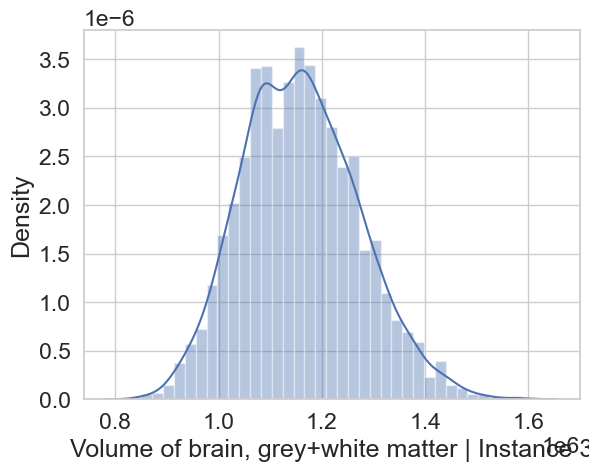

In [45]:
sns.distplot(df_IDPs_vs_age['Volume of brain, grey+white matter | Instance 3'])

<Axes: xlabel='Volume of brain, grey+white matter | Instance 3', ylabel='Density'>

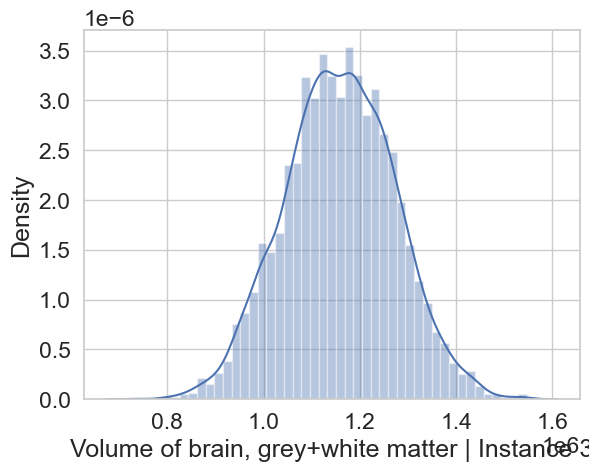

In [46]:
sns.distplot(ukbb_simulated_df['Volume of brain, grey+white matter | Instance 3'])

In [ ]:
ukbb_simulated_df.to_csv('ukbb_simulated_df.csv', index=False) # save simulated data for later use, i.e. modeling brain-age

# Brain-age modeling part - try hands on!

### Helper functions

In [47]:
def annotate_pearson(x, y, ax=None,**kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    ax = ax or plt.gca()
    r, _ = pearsonr(x, y)
    ax.annotate(f'pearson = {r:.2f}', xy=(.1, .95), xycoords=ax.transAxes)

In [48]:
def annotate_pearson_r2_mae(x, y, ax=None,**kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    ax = ax or plt.gca()
    r, _ = pearsonr(x, y)
    ax.annotate(f'pearson = {r:.2f}', xy=(.1, .90), xycoords=ax.transAxes)
    r2 = metrics.r2_score(x, y)
    ax.annotate(f'R2 = {r2:.2f}', xy=(.1, .85), xycoords=ax.transAxes)
    mae = metrics.mean_absolute_error(x, y)
    ax.annotate(f'MAE = {mae:.2f}', xy=(.1, .80), xycoords=ax.transAxes)

In [49]:
def get_pca(df, n_components = 2):
    cols = ['PCA{}'.format(c+1) for c in range(n_components)]
    pca = PCA(n_components=n_components, random_state=42)
    return pd.DataFrame(pca.fit_transform(df), index=df.index, columns=cols)

In [50]:
features_pca = get_pca(ukbb_simulated_df.drop(columns=['Age at recruitment']))
features_pca.head()

,PCA1,PCA2
0,-39403.177473,157217.716624
1,201899.068445,41269.264623
2,-12213.902940,-101530.057249
3,-266185.937891,-59930.257067
4,-20124.414908,-76579.662566


In [51]:
sns.set(font_scale=1.5)

(array([-800000., -600000., -400000., -200000.,       0.,  200000.,
         400000.,  600000.,  800000.]),
 [Text(-800000.0, 0, '−800000'),
  Text(-600000.0, 0, '−600000'),
  Text(-400000.0, 0, '−400000'),
  Text(-200000.0, 0, '−200000'),
  Text(0.0, 0, '0'),
  Text(200000.0, 0, '200000'),
  Text(400000.0, 0, '400000'),
  Text(600000.0, 0, '600000'),
  Text(800000.0, 0, '800000')])

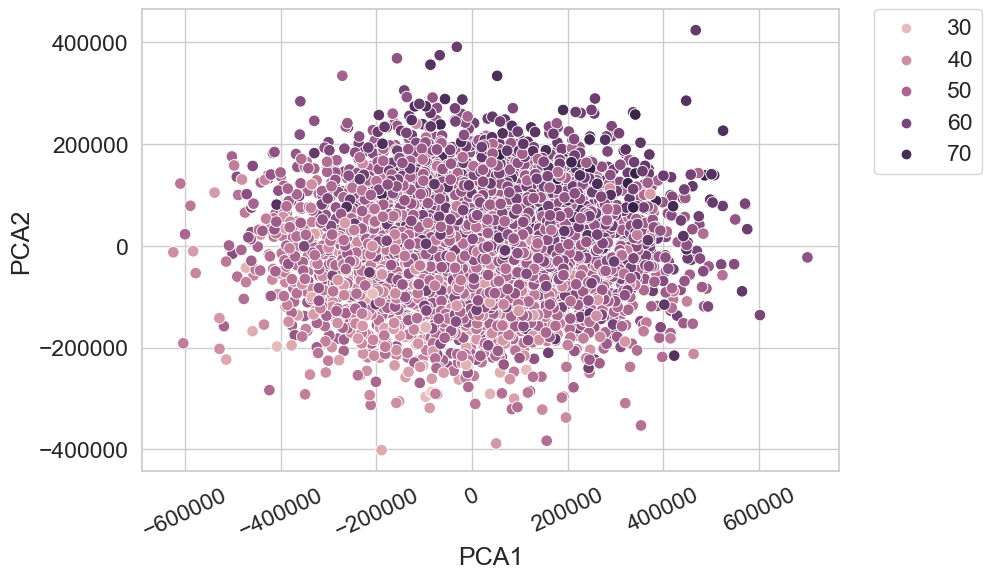

In [52]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(9, 6))
sns.scatterplot(x=features_pca['PCA1'], y=features_pca['PCA2'], hue=ukbb_simulated_df['Age at recruitment'], s=70, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=25)

In [53]:
def regression_cv(model, X, y, title):
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = []
    y_train_all = []
    y_test_all = []
    pred_train_all = []
    pred_test_all = []
    splits = []
    fig, ax = plt.subplots(1, 2, figsize=(12,5.5))
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        m = clone(model)
        m.fit(X_train, y_train)

        pred_test = m.predict(X_test)
        y_test_all += y_test.tolist()
        pred_test_all += pred_test.tolist()
        pred_train = m.predict(X_train)
        y_train_all += y_train.tolist()
        pred_train_all += pred_train.tolist()
        
        scores.append({
        'train_mse': metrics.mean_squared_error(y_train, pred_train),
        'test_mse': metrics.mean_squared_error(y_test, pred_test)
        })
        splits += [i] * len(y_test)
        
        
    scores = pd.DataFrame(scores)
    print(scores)
    print('Average:')
    print(scores.mean())
    val_max = max(np.max(y_test_all), np.max(pred_test_all))
    cmap = plt.get_cmap('tab20c')
    ax[1].scatter(y_test_all, pred_test_all, color=[cmap(i) for i in splits], alpha=0.8)
    ax[1].set_xlabel('Actual Age ')
    ax[1].set_ylabel('Predicted Age');
    ax[1].set_xlim([25, 85])
    ax[1].set_ylim([20, 90])
    annotate_pearson_r2_mae(y_test_all, pred_test_all, ax[1])
    plt.show()

   train_mse   test_mse
0  28.814154  26.376743
1  28.603626  28.216250
2  28.433865  29.806411
3  28.846915  26.038297
4  28.304836  30.925950
5  28.552445  28.749918
6  28.469300  29.467754
7  28.747172  26.982201
8  28.099104  32.793232
9  28.577980  28.497961
Average:
train_mse    28.544940
test_mse     28.785472
dtype: float64


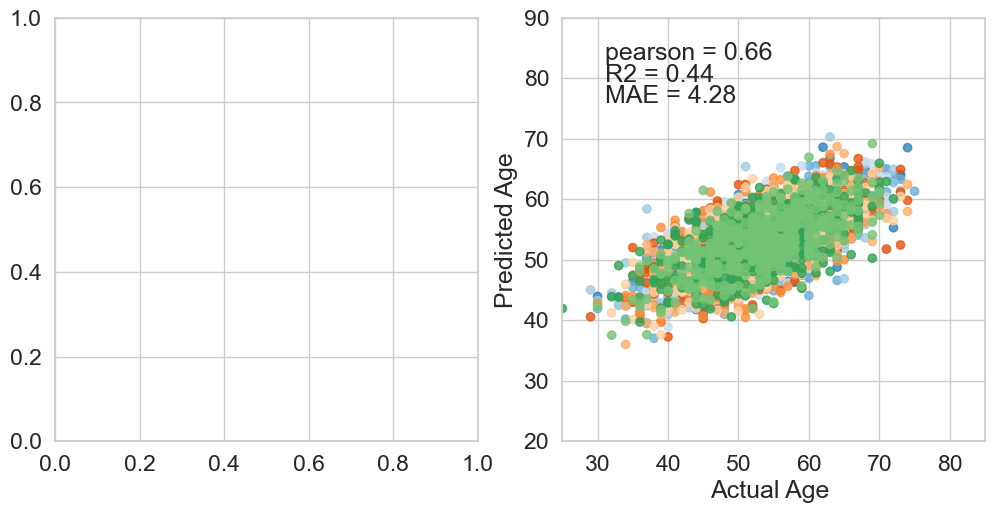

In [54]:
regression_cv(linear_model.Lasso(alpha=1, max_iter=100000), ukbb_simulated_df.drop(columns=['Age at recruitment']), ukbb_simulated_df['Age at recruitment'], 'Age at recruitment')